# Βασική Εξίσωση Παρατήρησης DORIS

Μέσω του Doppler count, το σύστημα DORIS μπορεί να παρατηρήσει με μεγάλη ακρίβεια το ρυθμό μεταβολής της απόστασης δορυφόρου-δέκτη (range-rate). Η βασική (απλοϊκή) εξίσωση παρατήρησης, είναι:

$$ \frac{\phi (t_2) - \phi (t_1)}{\Delta t} \cdot \frac{c}{f} = \frac{\rho (t_2) - \rho (t_1)}{\Delta t} $$ σε [m/sec], όπου $\rho (t)$ είναι η (ψευδο-)απόσταση δορυφόρου - σταθμού.

In [27]:
# import dsoclasses
import datetime
import attotime
import numpy as np
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

Θα χρησιμοποιήσουμε ένα αρχείο (DORIS) RINEX και το αντίστοιχο sp3.

In [28]:
drinex = "../data/s6arx24001.001"
dsp3 = "../data/ssas6a20.b23357.e24001.DG_.sp3.001"

Θα χρειστεί να υπολογίσουμε (με παρεμβολή) την θέση του δορυφόρου στις εποχές των μετρήσεων. 

In [29]:
sp3 = sp3c.Sp3(dsp3)
satid = sp3.sat_ids[0]
sp3_data = sp3.get_satellite(satid, True)
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

In [30]:
rnx = DorisRinex(drinex)

# Επιλογή DORIS beacon
diob = 'D31'

# συν/νες DIOB
# https://ids-doris.org/network/sitelogs/station.html?code=DIONYSOS
diob_xyz=[4595212.468, 2039473.691, 3912617.891]

In [31]:
## Optional
## Correction of Abberation
def geometric_range(rsat, rrec): return np.linalg.norm(rsat-rrec)
def sat_at_emission_time(rsta, t_reception, interpolator):
    t_emission = t_reception
    x, y, z = interpolator.at(t_emission)
    while True:
        r = geometric_range(np.array((x,y,z)), rsta)
        dt = r / gs.C
        t_emission = t_reception - fsec2asec(dt)
        xnew, ynew, znew = interpolator.at(t_emission)
        if abs(xnew-x)<.1 and abs(ynew-y)<.1 and abs(znew-z)<.1:
            return xnew, ynew, znew, dt
        else:
            x=xnew; y=ynew; z=znew;

# αρχικά, δεν υπάρχει προηγούμενη μέτρηση ...
t1=None
t = []; res=[];
for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            # χρειαζόμαστε την διόρθωση του ρολογιού του δορυφόρου, για να "βρεθούμε" στην
            # κλίμακα TAI:
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            # συν/νες δορυφόρου την εποχή της μέτρησης
            satx, saty, satz = intrp.at(t2)
            # satx, saty, satz, dt = sat_at_emission_time(np.array(diob_xyz), t2, intrp)
            # print("Signal travel time is {:.3f} [sec]".format(dt))
            # μέτρηση φάσης
            L2 = data['L1']['value']
            # απόσταση δορυφόρου-σταθμού
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            # αν έχουμε προηγούμενη παρατήρηση ...
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                # computed range-rate
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                # observed range-rate
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                # very loose outlier detection
                if abs(orr - crr) > 100.:
                    pass
                else:
                    t.append(at2pt(t2))
                    res.append(orr - crr)
            r1 = r2
            t1 = t2
            L1 = L2

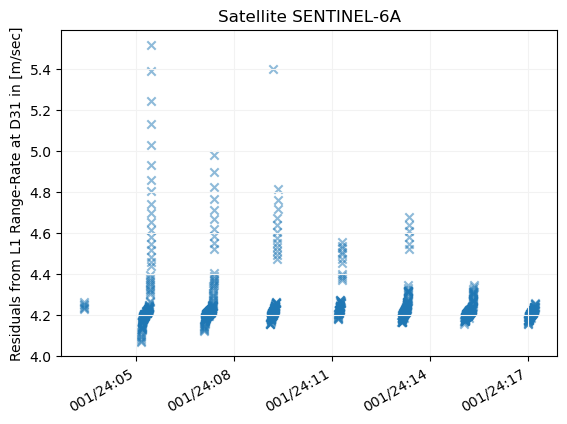

In [32]:
fig, ax = plt.subplots()
plt.scatter(t, res, alpha=0.5, label="res2", marker='x')
ax.grid(color='0.95')
plt.ylabel("Residuals from L1 Range-Rate at {:} in [m/sec]".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Συσχέτιση Με Γωνία Ύψους

In [33]:
lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

def azele(R, rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

t1=None
els = []; res=[];
for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            satx, saty, satz = intrp.at(t2)
            L2 = data['L1']['value']
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            _, _, el = azele(Rc2t, np.array((satx, saty, satz)), np.array(diob_xyz))
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                if abs(orr - crr) > 100.:
                    pass
                else:
                    res.append(orr - crr)
                    els.append(np.degrees(el))
            r1 = r2
            t1 = t2
            L1 = L2

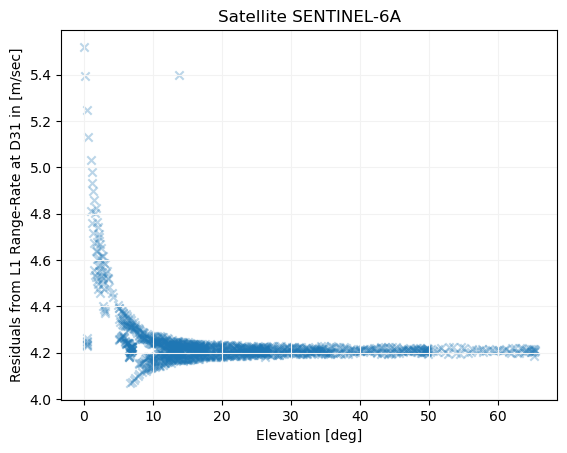

In [35]:
plt.scatter(els, res, alpha=0.3, marker='x')
plt.grid(color='0.95')
plt.ylabel("Residuals from L1 Range-Rate at {:} in [m/sec]".format(diob))
plt.xlabel("Elevation [deg]")
plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()